In [75]:
import json
import gcsfs
gcs = gcsfs.GCSFileSystem()
import os
SCRATCH_BUCKET = os.environ['PANGEO_SCRATCH']

In [2]:
from dask_gateway import GatewayCluster, Gateway
from distributed import Client
g = Gateway()
g.list_clusters()

[]

In [69]:
#cluster = g.connect(g.list_clusters()[0].name)

In [71]:
options = g.cluster_options()
options.worker_cores = 2; options.worker_memory = 4
# Create a cluster with those options
cluster = g.new_cluster(options)

In [72]:
g.list_clusters()

[ClusterReport<name=prod.13c14c9f129b48deb7e9d7853bacc129, status=RUNNING>]

In [73]:
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.13c14c9f129b48deb7e9d7853bacc129/status,


In [74]:
cluster.scale(40)

### Create random data

In [76]:
n = 2105319
time = np.random.uniform(13000, 18500, n)
latitude = np.random.uniform(-80, 80, n) 
longitude = np.random.uniform(-180, 180, n)

In [79]:
import xarray as xr, numpy as np
from datetime import datetime
ds1 = xr.Dataset(
    data_vars = dict(
        Anomalies = ( ["i", "pressure"], np.random.uniform(-1, 5, n).reshape(n,1) ),
        Mean = ( ["i", "pressure"], np.random.uniform(0, 2, n).reshape(n,1) ),
    ),
    coords=dict(
        i = (["i"], np.arange(n) ),
        time = ( ["i"], time),
        latitude = ( ["i"], latitude ),
        longitude = ( ["i"], longitude),
        pressure = (["pressure"], np.array([5]) ),
    ),
    attrs=dict(
        description = 'Description',
        pindex = 4,
        number_of_harmonics = 2,
        window_size = 500e3,
        creation_date = str( datetime.now() )
    ),
)


dsc = ds1.chunk()
path_to_zarrstore = f'{SCRATCH_BUCKET}/random_dataset.zarr'
mapper = gcs.get_mapper(path_to_zarrstore)

%time dsc.to_zarr(mapper, consolidated=True)

CPU times: user 381 ms, sys: 90.9 ms, total: 472 ms
Wall time: 13.9 s


### Define functions and start timing

In [81]:
import zarr, numpy as np, dask

def load():
    mapper = gcs.get_mapper(path_to_zarrstore)
    z = zarr.open_consolidated(mapper)
    data, lat, lon, time = z.Anomalies[:][:,0],z.latitude[:],z.longitude[:],z.time[:]    
    return data, lat, lon, time

@dask.delayed
def function_load():
    data, lat, lon, time = load()
    ### Do computation with lat, lon, data, time    
    return None

@dask.delayed
def function_scattered(data_scattered, lat_scattered, lon_scattered, time_scattered):
    data, lat, lon, time = data_scattered, lat_scattered, lon_scattered, time_scattered
    ### Do computation with lat, lon, data, time
    return None

data, lat, lon, time = load()

### The loaded data are numpy arrays of equal size stored as zarr (by first creating xarray dataset)

In [83]:
print([arr.dtype for arr in (data, lat,lon, time)])

[dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64')]


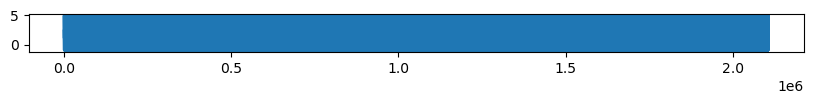

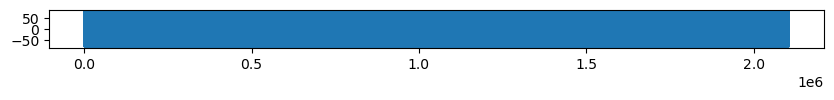

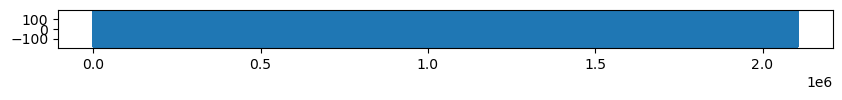

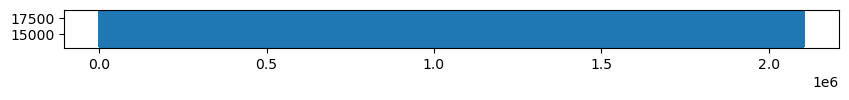

In [84]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,0.5));plt.plot(data);plt.show();
plt.figure(figsize=(10,0.5));plt.plot(lat);plt.show()
plt.figure(figsize=(10,0.5));plt.plot(lon);plt.show()
plt.figure(figsize=(10,0.5));plt.plot(time);plt.show()

Scatter data beforehand:

In [85]:
data_scat,lat_scat,lon_scat,time_scat = client.scatter(data),client.scatter(lat),client.scatter(lon),client.scatter(time)

In [86]:
client.who_has()

Key,Copies,Workers
ndarray-7323471cd3a69139336a35e489a9d54a,1,tls://10.8.14.3:38781
ndarray-0b9523a2a0921f3cf715429bd91f6149,1,tls://10.8.14.3:38781
ndarray-e6c9da7f01cdc0b61f6cb3f4b1824777,1,tls://10.8.6.2:38483
ndarray-75fdede31cea004ad0cbf372c123b8c1,1,tls://10.8.6.2:38483


In [88]:
client.who_has()

Key,Copies,Workers
ndarray-7323471cd3a69139336a35e489a9d54a,1,tls://10.8.14.3:38781
ndarray-0b9523a2a0921f3cf715429bd91f6149,1,tls://10.8.14.3:38781
ndarray-e6c9da7f01cdc0b61f6cb3f4b1824777,1,tls://10.8.6.2:38483
ndarray-75fdede31cea004ad0cbf372c123b8c1,1,tls://10.8.6.2:38483


Scatter data with 'broadcast=True' :

In [89]:
data_bcast, lat_bcast, lon_bcast, time_bcast = client.scatter(data, broadcast=True), client.scatter(lat, broadcast=True), client.scatter(lon, broadcast=True), client.scatter(time, broadcast=True)

In [90]:
client.who_has()

Key,Copies,Workers
ndarray-7323471cd3a69139336a35e489a9d54a,1,tls://10.8.3.2:38825
ndarray-0b9523a2a0921f3cf715429bd91f6149,1,tls://10.8.15.3:42249
ndarray-e6c9da7f01cdc0b61f6cb3f4b1824777,1,tls://10.8.5.5:44431
ndarray-75fdede31cea004ad0cbf372c123b8c1,1,tls://10.8.12.4:42007


In [91]:
client.has_what()

{'tls://10.8.10.2:37607': (),
 'tls://10.8.10.4:44409': (),
 'tls://10.8.10.5:39391': (),
 'tls://10.8.11.3:37477': (),
 'tls://10.8.11.4:38683': (),
 'tls://10.8.11.5:46811': (),
 'tls://10.8.12.2:40717': (),
 'tls://10.8.12.3:32995': (),
 'tls://10.8.12.4:42007': ('ndarray-75fdede31cea004ad0cbf372c123b8c1',),
 'tls://10.8.13.3:41187': (),
 'tls://10.8.13.4:36067': (),
 'tls://10.8.13.5:36789': (),
 'tls://10.8.14.3:38781': (),
 'tls://10.8.14.4:38569': (),
 'tls://10.8.14.5:46193': (),
 'tls://10.8.15.3:42249': ('ndarray-0b9523a2a0921f3cf715429bd91f6149',),
 'tls://10.8.15.4:37031': (),
 'tls://10.8.15.5:46411': (),
 'tls://10.8.3.2:38825': ('ndarray-7323471cd3a69139336a35e489a9d54a',),
 'tls://10.8.3.4:39743': (),
 'tls://10.8.3.5:44729': (),
 'tls://10.8.4.2:41613': (),
 'tls://10.8.4.4:37657': (),
 'tls://10.8.4.5:36027': (),
 'tls://10.8.5.3:32795': (),
 'tls://10.8.5.4:46185': (),
 'tls://10.8.5.5:44431': ('ndarray-e6c9da7f01cdc0b61f6cb3f4b1824777',),
 'tls://10.8.6.2:38483': (),
 'tls://10.8.6.4:37867': (),
 'tls://10.8.6.5:39871': (),
 'tls://10.8.7.2:42589': (),
 'tls://10.8.7.3:34481': (),
 'tls://10.8.7.5:45081': (),
 'tls://10.8.8.2:41635': (),
 'tls://10.8.8.4:38803': (),
 'tls://10.8.8.5:43455': (),
 'tls://10.8.9.3:44683': (),
 'tls://10.8.9.4:40655': (),
 'tls://10.8.9.5:42585': (),
 'tls://10.9.61.3:45547': ()}

In [32]:
#client.get_task_stream()

In [92]:
cluster.scale(0)

In [93]:
cluster.close()

In [94]:
cluster.shutdown()

In [96]:
client.close()